In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
import statsmodels.api as sm
import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
import re
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load datasets
train_df = pd.read_csv("/Users/zionmicwu/Desktop/train.csv")
test_df = pd.read_csv("/Users/zionmicwu/Desktop/test.csv")
test_copy = test_df.copy()

In [3]:
# Overview
print("Train Data Overview:")
print(train_df.info())
print("\nTest Data Overview:")
print(test_df.info())

print("\nTrain Data Summary:")
print(train_df.describe())

Train Data Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None

Test Data Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Pas

In [4]:
duplicate_rows = train_df.duplicated().sum()
print(f"Number of duplicate rows in train dataset: {duplicate_rows}")
if duplicate_rows > 0:
    train_df = train_df.drop_duplicates()
    print("Duplicate rows removed from train dataset.")

Number of duplicate rows in train dataset: 0


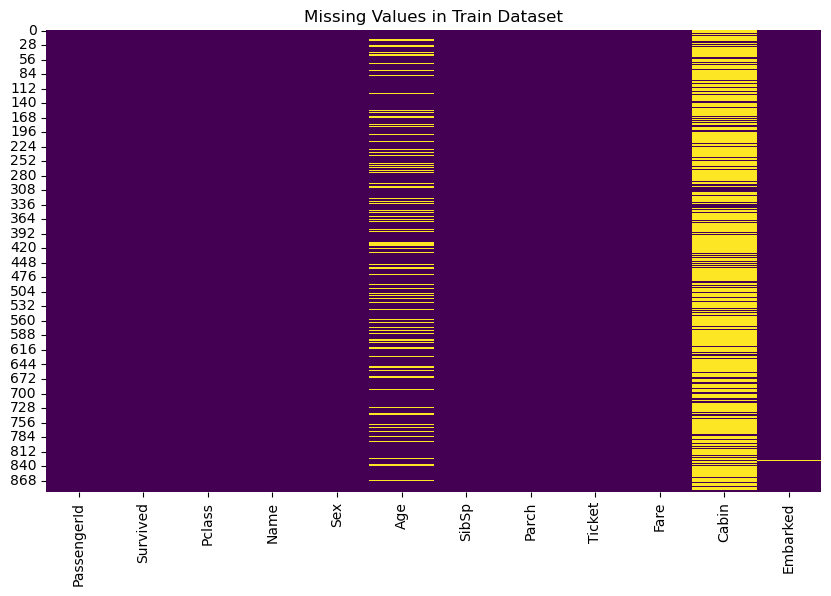

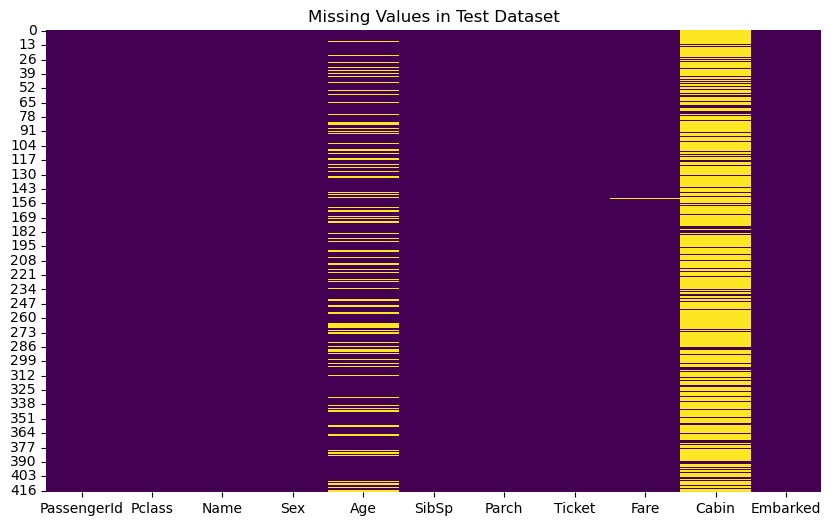

In [5]:
# Visualizing missing values
plt.figure(figsize=(10, 6))
sns.heatmap(train_df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values in Train Dataset")
plt.show()

plt.figure(figsize=(10, 6))
sns.heatmap(test_df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values in Test Dataset")
plt.show()

In [6]:
# Handle missing values
train_df['Age'].fillna(train_df.groupby('Pclass')['Age'].transform('median'), inplace=True)
test_df['Age'].fillna(test_df.groupby('Pclass')['Age'].transform('median'), inplace=True)

train_df['Embarked'].fillna(train_df['Embarked'].mode()[0], inplace=True)

test_df['Fare'].fillna(test_df['Fare'].median(), inplace=True)

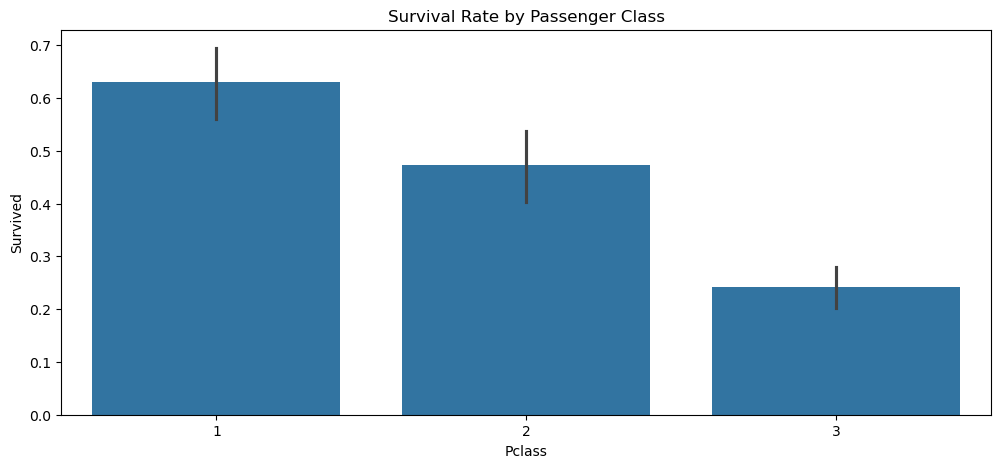

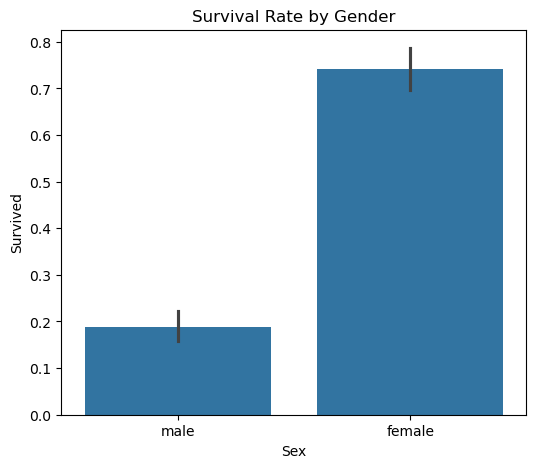

In [7]:
# Checking survival rate by class and gender
plt.figure(figsize=(12, 5))
sns.barplot(x='Pclass', y='Survived', data=train_df)
plt.title("Survival Rate by Passenger Class")
plt.show()

plt.figure(figsize=(6, 5))
sns.barplot(x='Sex', y='Survived', data=train_df)
plt.title("Survival Rate by Gender")
plt.show()

In [8]:
# Convert 'Sex' column to numerical
train_df["Sex"] = train_df["Sex"].map({"male": 0, "female": 1})
test_df["Sex"] = test_df["Sex"].map({"male": 0, "female": 1})

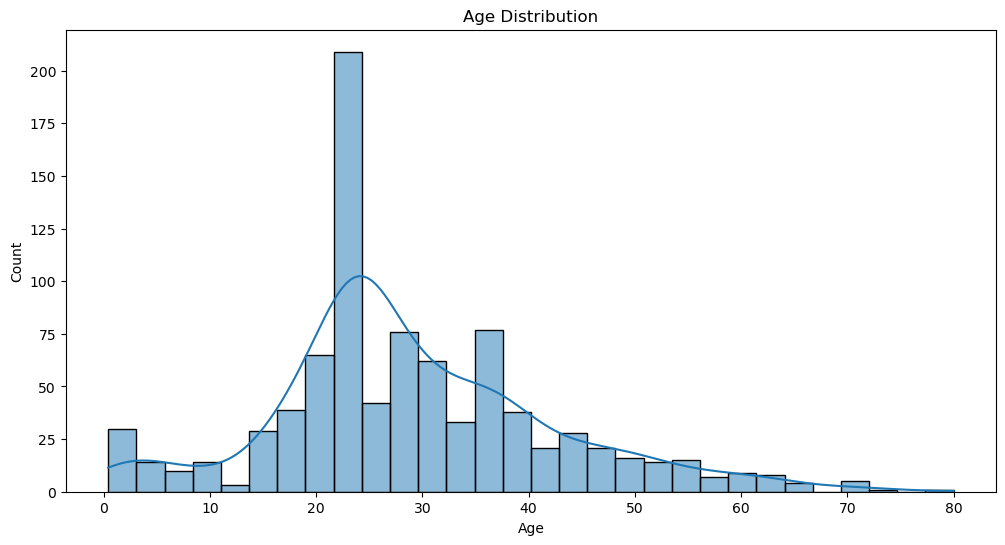

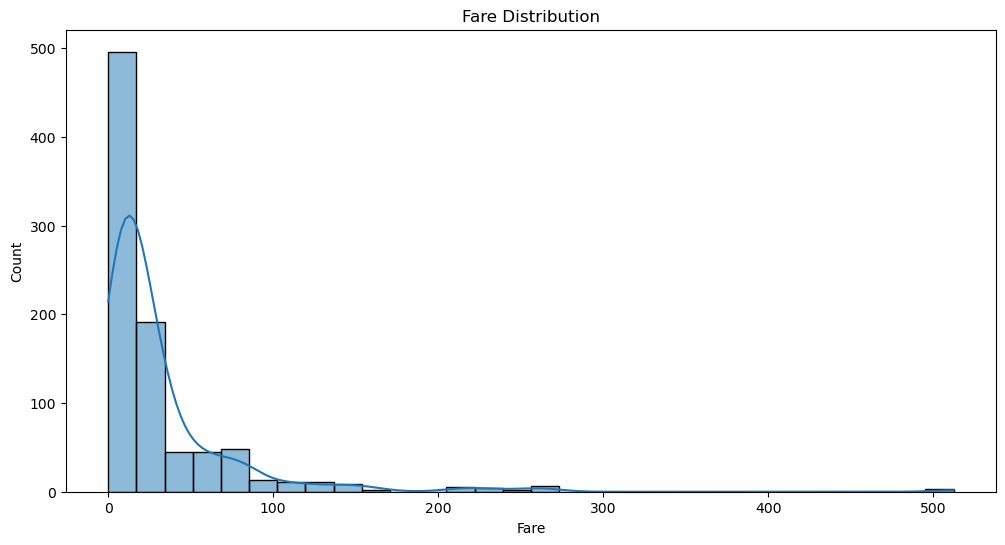

In [9]:
# Feature distributions
plt.figure(figsize=(12, 6))
sns.histplot(train_df["Age"].dropna(), kde=True, bins=30)
plt.title("Age Distribution")
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(train_df["Fare"].dropna(), kde=True, bins=30)
plt.title("Fare Distribution")
plt.show()

In [10]:
# Apply log transformation (adding 1 to avoid log(0) error)
train_df['Fare'] = np.log1p(train_df['Fare'])
test_df['Fare'] = np.log1p(test_df['Fare'])

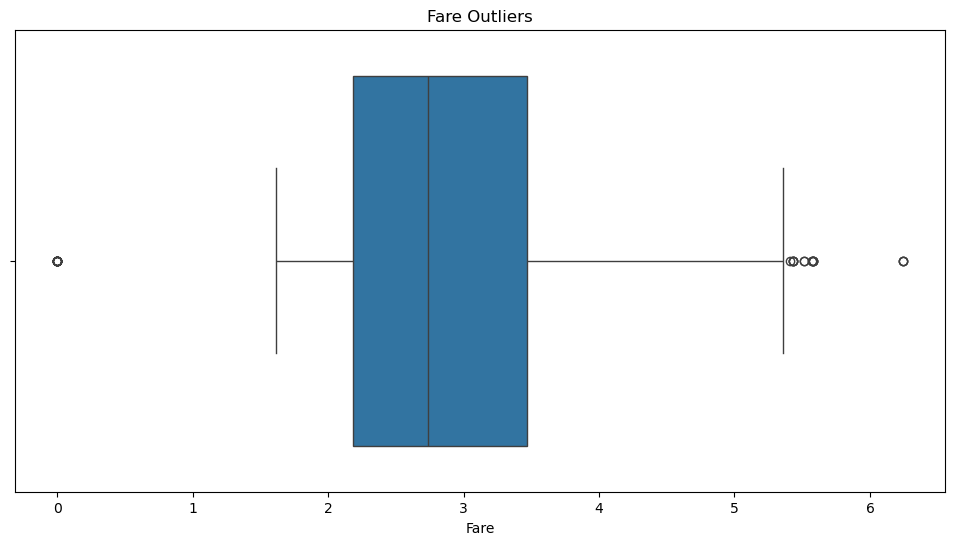

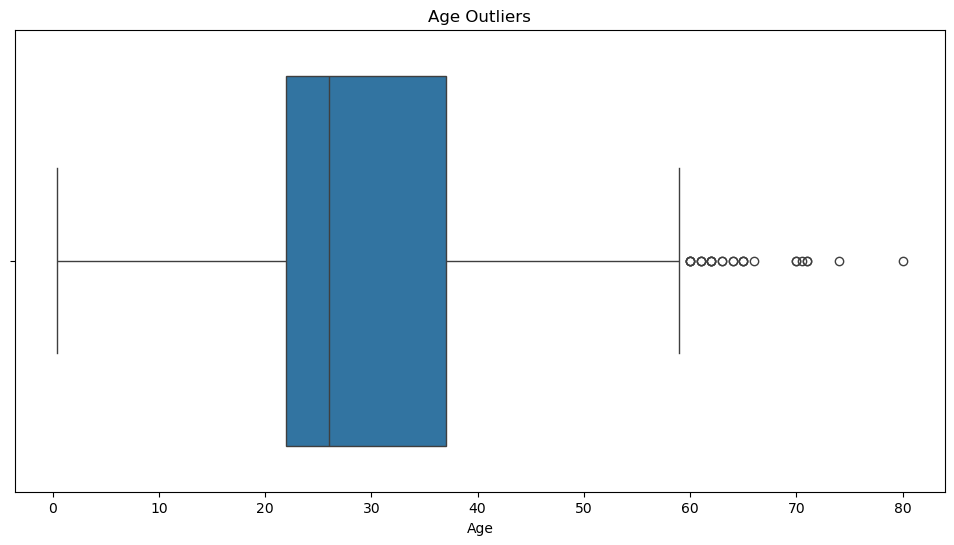

In [11]:
# Detecting Outliers using Boxplots
plt.figure(figsize=(12, 6))
sns.boxplot(x=train_df["Fare"])
plt.title("Fare Outliers")
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x=train_df["Age"])
plt.title("Age Outliers")
plt.show()

In [12]:
# Handling outliers
train_df = train_df[train_df['Fare'] < train_df['Fare'].quantile(0.99)]  # Removing extreme fare outliers
train_df = train_df[train_df['Age'] < train_df['Age'].quantile(0.99)]  # Removing extreme age outliers

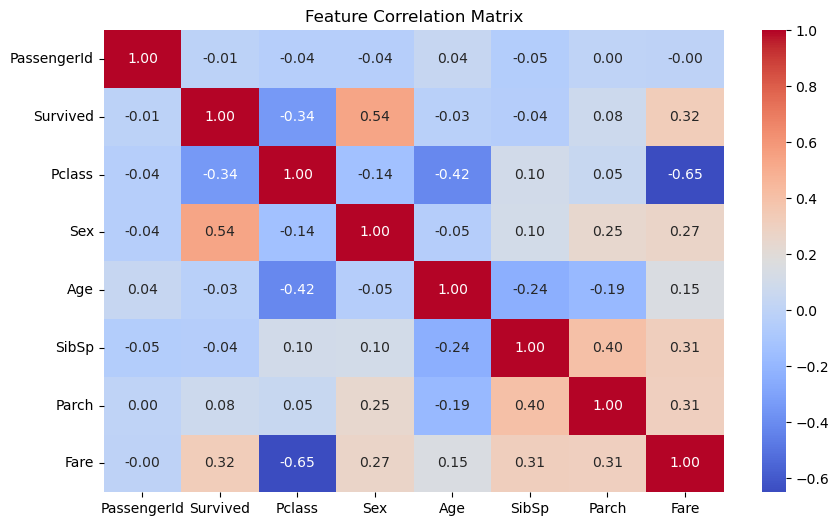

In [13]:
# Correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(train_df.select_dtypes(include=['number']).corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Feature Correlation Matrix")
plt.show()

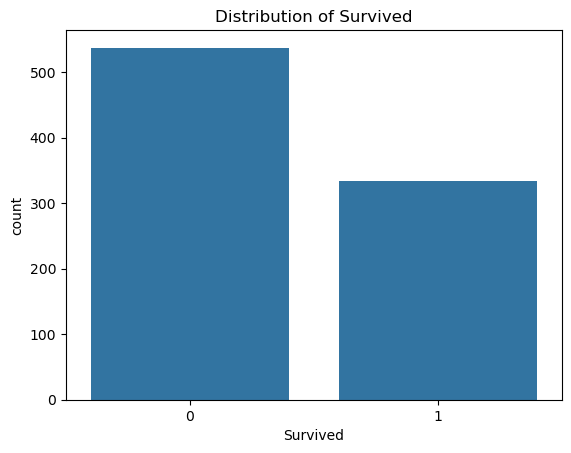

In [14]:
sns.countplot(x=train_df['Survived'])
plt.title("Distribution of Survived")
plt.show()

In [15]:
# Feature Engineering
train_df["FamilySize"] = train_df["SibSp"] + train_df["Parch"] + 1
test_df["FamilySize"] = test_df["SibSp"] + test_df["Parch"] + 1

train_df['IsAlone'] = (train_df['FamilySize'] == 1).astype(int)  # Creating IsAlone feature
test_df['IsAlone'] = (test_df['FamilySize'] == 1).astype(int)


In [16]:
# Extract title from "Name" and categorize titles
def extract_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return ""

train_df["Title"] = train_df["Name"].apply(extract_title)
test_df["Title"] = test_df["Name"].apply(extract_title)


def encode_title(title):
    if title in ['Mr', 'Mrs', 'Miss', 'Master']:
        return title
    elif title in ['Mlle', 'Ms']:
        return 'Miss'
    elif title in ['Mme']:
        return 'Mrs'
    elif title in ['Dr', 'Major', 'Col', 'Capt', 'Rev']:
        return 'Officer'
    elif title in ['Don', 'Sir', 'the Countess', 'Lady', 'Jonkheer']:
        return 'Noble'
    else:
        return 'Other'

# Apply title encoding
train_df["Title"] = train_df["Title"].apply(encode_title).astype('category')
test_df["Title"] = test_df["Title"].apply(encode_title).astype('category')

# Print all unique titles found in train and test datasets
print("Unique Titles in Train Dataset:", train_df["Title"].unique())
print("Unique Titles in Test Dataset:", test_df["Title"].unique())

Unique Titles in Train Dataset: ['Mr', 'Mrs', 'Miss', 'Master', 'Noble', 'Officer', 'Other']
Categories (7, object): ['Master', 'Miss', 'Mr', 'Mrs', 'Noble', 'Officer', 'Other']
Unique Titles in Test Dataset: ['Mr', 'Mrs', 'Miss', 'Master', 'Officer', 'Other']
Categories (6, object): ['Master', 'Miss', 'Mr', 'Mrs', 'Officer', 'Other']


In [17]:
# Filter categorical features
categorical_features = ["Pclass", "Embarked", "Title"]

# Prepare final datasets
X = train_df[["Sex", "Age", "Fare", "FamilySize", "IsAlone"]+categorical_features]
test = test_df[["Sex", "Age", "Fare", "FamilySize", "IsAlone"]+categorical_features]
X = pd.get_dummies(X, columns=categorical_features, drop_first=True).astype(int)
test = pd.get_dummies(test, columns=categorical_features, drop_first=True).astype(int)
y = train_df["Survived"]

# Align train and test datasets
X, test = X.align(test, join='left', axis=1)
test.fillna(0, inplace=True)

# Display first several rows of train set after data preparation and feature engineering
print(X.head())

   Sex  Age  Fare  FamilySize  IsAlone  Pclass_2  Pclass_3  Embarked_Q  \
0    0   22     2           2        0         0         1           0   
1    1   38     4           2        0         0         0           0   
2    1   26     2           1        1         0         1           0   
3    1   35     3           2        0         0         0           0   
4    0   35     2           1        1         0         1           0   

   Embarked_S  Title_Miss  Title_Mr  Title_Mrs  Title_Noble  Title_Officer  \
0           1           0         1          0            0              0   
1           0           0         0          1            0              0   
2           1           1         0          0            0              0   
3           1           0         0          1            0              0   
4           1           0         1          0            0              0   

   Title_Other  
0            0  
1            0  
2            0  
3            0  
4

In [18]:
# Decision tree models don't need scaling, so the following steps for scaling are removed.
# scaler = StandardScaler()
# X[['Age', 'Fare', 'FamilySize']] = scaler.fit_transform(X[['Age', 'Fare', 'FamilySize']])
# test[['Age', 'Fare', 'FamilySize']] = scaler.fit_transform(test[['Age', 'Fare', 'FamilySize']])

# Split dataset (80% training, 20% testing)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [19]:
# Set up cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define models
models = {
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosted Trees": GradientBoostingClassifier(),
    "Extra Trees": ExtraTreesClassifier()
}

# Define hyperparameters for tuning
param_grid = {
    'n_estimators': [50, 100, 500, 1000],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [4, 6, 8, 10]
}

best_models = {}
results = []

# Hyperparameter tuning and model evaluation
for name, model in models.items():
    print(f"Tuning and Evaluating: {name}")
    if name in ["Random Forest", "Extra Trees"]:
        grid_search = GridSearchCV(model, {**param_grid, 'criterion': ['gini', 'entropy']}, cv=cv, scoring='accuracy', n_jobs=-1)
    else:
        grid_search = GridSearchCV(model, param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
    
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    best_models[name] = best_model
    
    cv_scores = cross_val_score(best_model, X_train, y_train, cv=cv, scoring='accuracy')
    y_pred = best_model.predict(X_valid)
    accuracy = accuracy_score(y_valid, y_pred)
    precision = precision_score(y_valid, y_pred, average='weighted')
    recall = recall_score(y_valid, y_pred, average='weighted')
    f1 = f1_score(y_valid, y_pred, average='weighted')
    auc = roc_auc_score(y_valid, best_model.predict_proba(X_valid)[:,1])
    results.append([name, accuracy, precision, recall, f1, auc])
    
    # Display the best parameters for every model
    print(f"{name} - Best Parameters: {grid_search.best_params_}")
    
# Display evaluation results as a table
results_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC'])
print(results_df)

Tuning and Evaluating: Random Forest
Random Forest - Best Parameters: {'criterion': 'entropy', 'max_depth': 6, 'max_features': 'sqrt', 'n_estimators': 50}
Tuning and Evaluating: Gradient Boosted Trees
Gradient Boosted Trees - Best Parameters: {'max_depth': 4, 'max_features': 'log2', 'n_estimators': 100}
Tuning and Evaluating: Extra Trees
Extra Trees - Best Parameters: {'criterion': 'gini', 'max_depth': 6, 'max_features': 'sqrt', 'n_estimators': 50}
                    Model  Accuracy  Precision    Recall  F1 Score       AUC
0           Random Forest  0.822857   0.823983  0.822857  0.818369  0.850539
1  Gradient Boosted Trees  0.811429   0.813318  0.811429  0.805666  0.870094
2             Extra Trees  0.817143   0.818640  0.817143  0.812041  0.842800


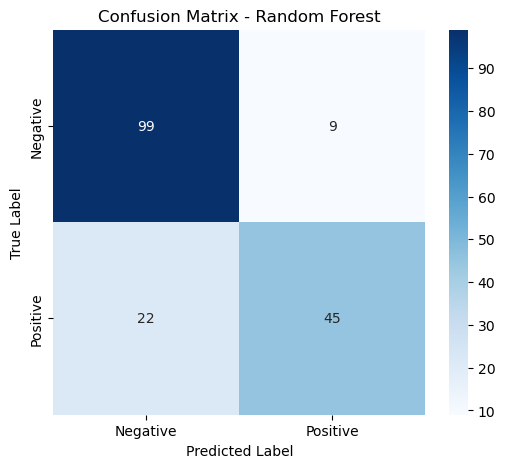

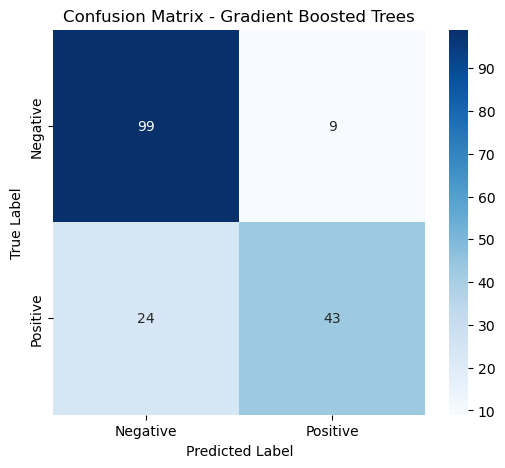

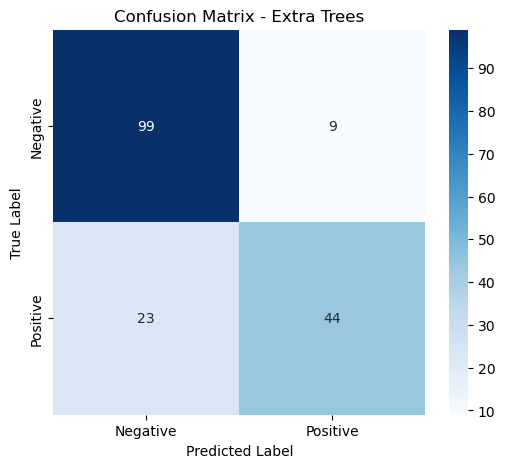

In [20]:
# Confusion matrix visualization
for name, model in best_models.items():
    y_pred = model.predict(X_valid)
    cm = confusion_matrix(y_valid, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

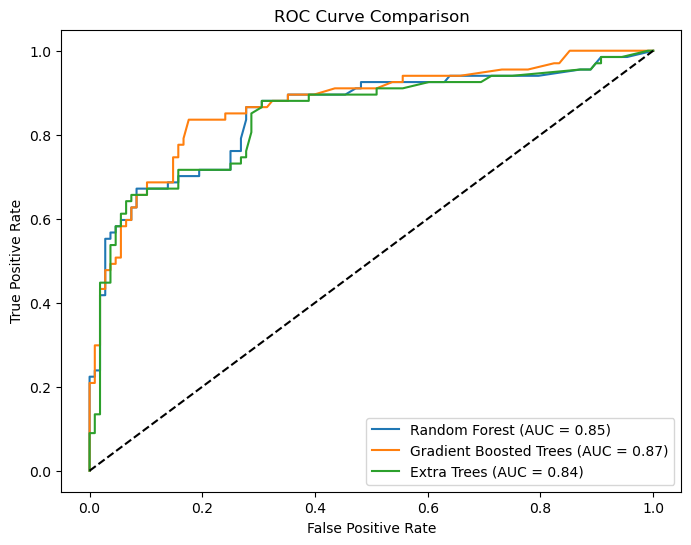

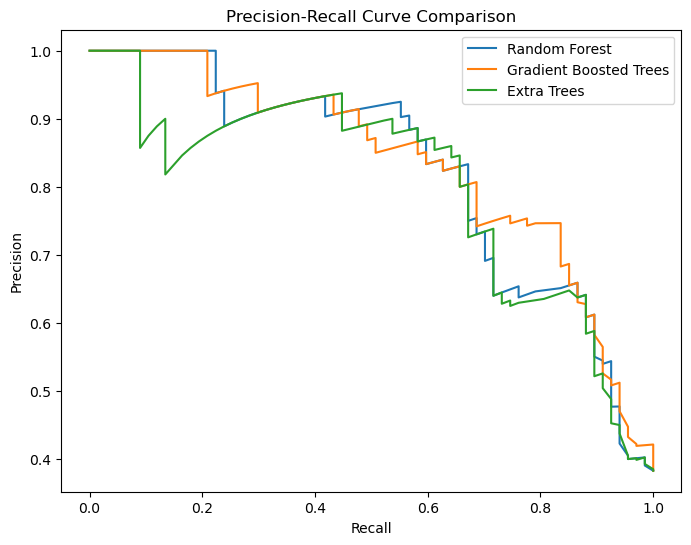

In [21]:
# ROC Curve
plt.figure(figsize=(8, 6))
for model_name, model in best_models.items():
    y_proba = model.predict_proba(X_valid)[:, 1]
    fpr, tpr, _ = roc_curve(y_valid, y_proba)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc_score(y_valid, y_proba):.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()

# Precision-Recall Curve
plt.figure(figsize=(8, 6))
for model_name, model in best_models.items():
    y_proba = model.predict_proba(X_valid)[:, 1]
    precision, recall, _ = precision_recall_curve(y_valid, y_proba)
    plt.plot(recall, precision, label=f"{model_name}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve Comparison")
plt.legend()
plt.show()

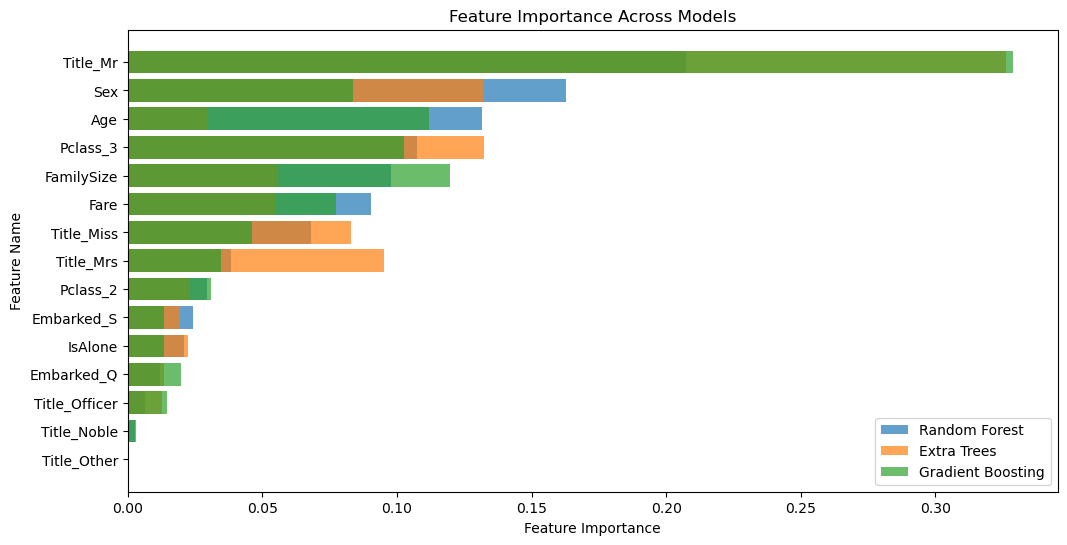

In [48]:
# Get feature importance from models
rf_importance = best_models["Random Forest"].feature_importances_
et_importance = best_models["Extra Trees"].feature_importances_
gb_importance = best_models["Gradient Boosted Trees"].feature_importances_

# Convert to DataFrame
feature_names = X.columns  # Assuming feature names are stored in X
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Random Forest": rf_importance,
    "Extra Trees": et_importance,
    "Gradient Boosting": gb_importance
})

# Sort by Random Forest importance for consistency
importance_df = importance_df.sort_values(by="Random Forest", ascending=False)

# Plot
plt.figure(figsize=(12, 6))
plt.barh(importance_df["Feature"], importance_df["Random Forest"], alpha=0.7, label="Random Forest")
plt.barh(importance_df["Feature"], importance_df["Extra Trees"], alpha=0.7, label="Extra Trees")
plt.barh(importance_df["Feature"], importance_df["Gradient Boosting"], alpha=0.7, label="Gradient Boosting")
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
plt.title("Feature Importance Across Models")
plt.legend()
plt.gca().invert_yaxis()
plt.show()

In [22]:
# Using Random Forest for predictions
test_predictions = best_models['Random Forest'].predict(test)

submission = pd.DataFrame({'PassengerId': test_copy['PassengerId'], 'Survived': test_predictions})
submission.to_csv('submission_random_forest.csv', index=False)

# Using Gradient Boosted Trees for predictions
test_predictions = best_models['Gradient Boosted Trees'].predict(test)

submission = pd.DataFrame({'PassengerId': test_copy['PassengerId'], 'Survived': test_predictions})
submission.to_csv('submission_gradient_boosted_tree.csv', index=False)

# Using Extra Trees for predictions
test_predictions = best_models['Extra Trees'].predict(test)

submission = pd.DataFrame({'PassengerId': test_copy['PassengerId'], 'Survived': test_predictions})
submission.to_csv('submission_extra_trees.csv', index=False)